## Import all necessary libraries


In [28]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load the DataSet

In [29]:
# Load the dataset
df = pd.read_csv('Housing.csv')

### Display Basic Information

In [30]:
#  Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [31]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [32]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


###  Data Visualization

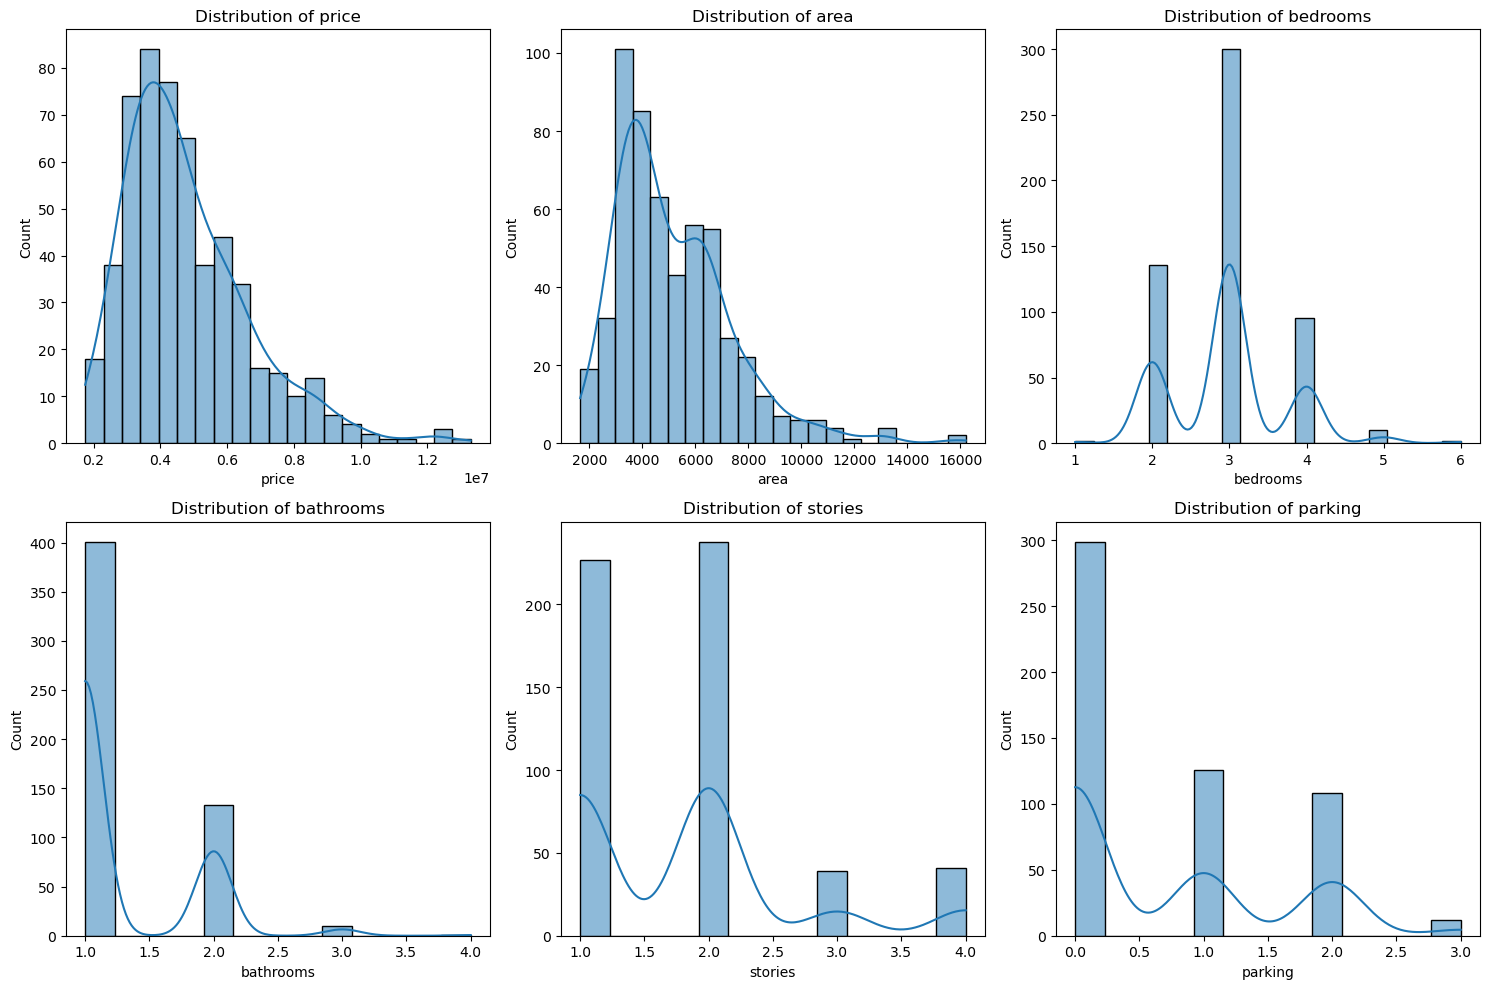

In [33]:
# Distribution of numerical features
plt.figure(figsize=(15, 10))
numerical_cols = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

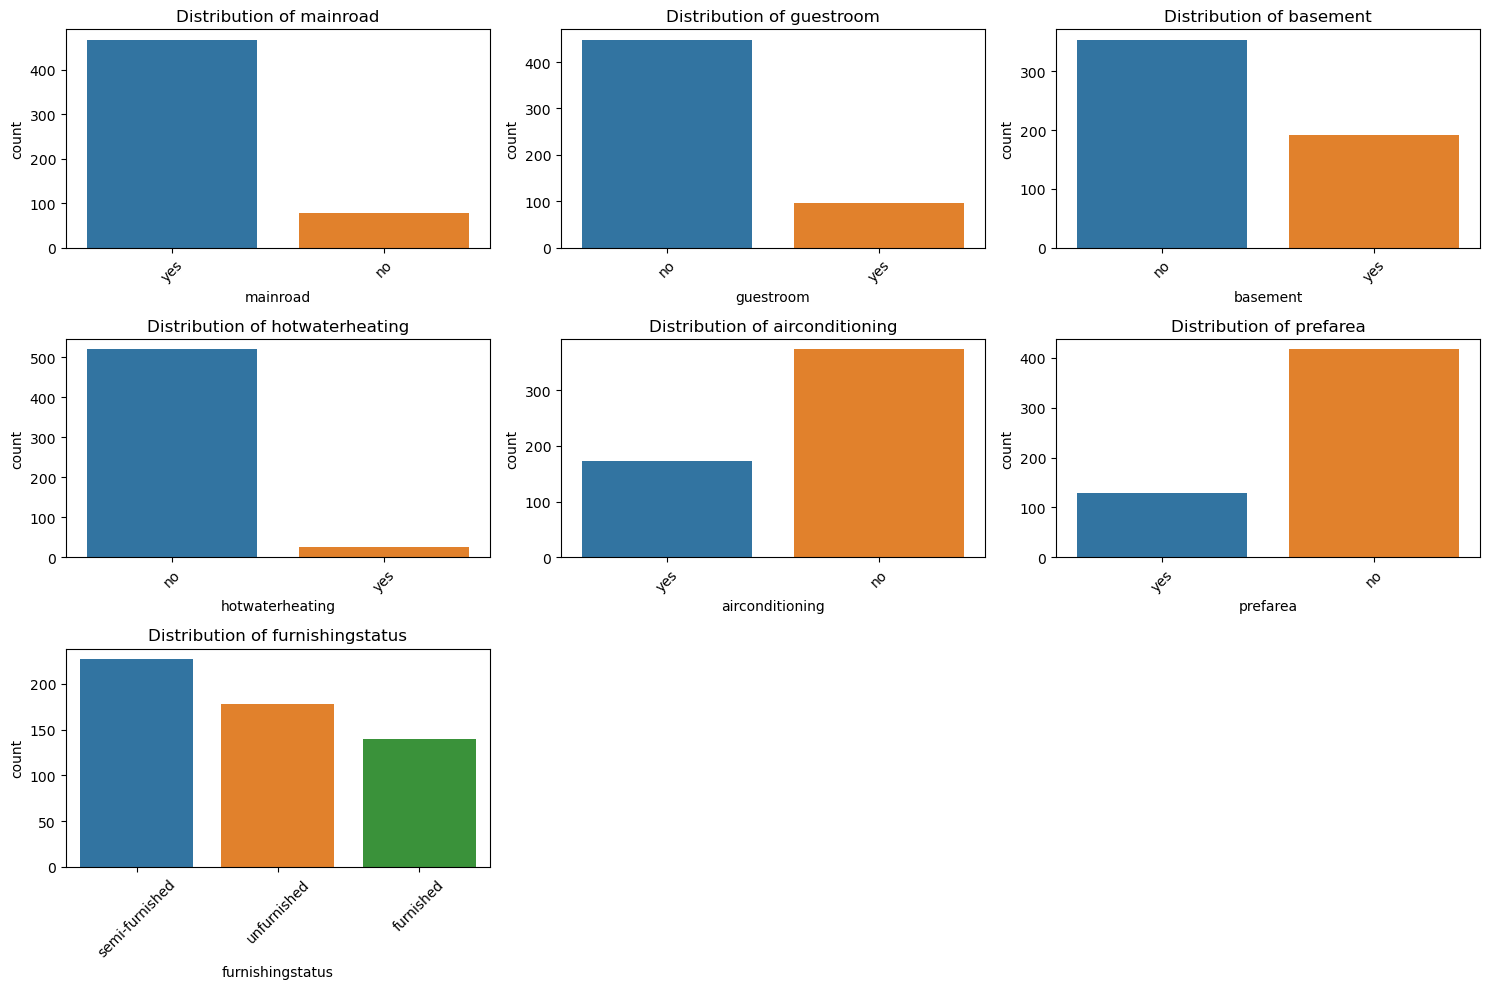

In [34]:
# Categorical features visualization
plt.figure(figsize=(15, 10))
categorical_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                   'airconditioning', 'prefarea', 'furnishingstatus']
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    if col == 'furnishingstatus':
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    else:
        sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

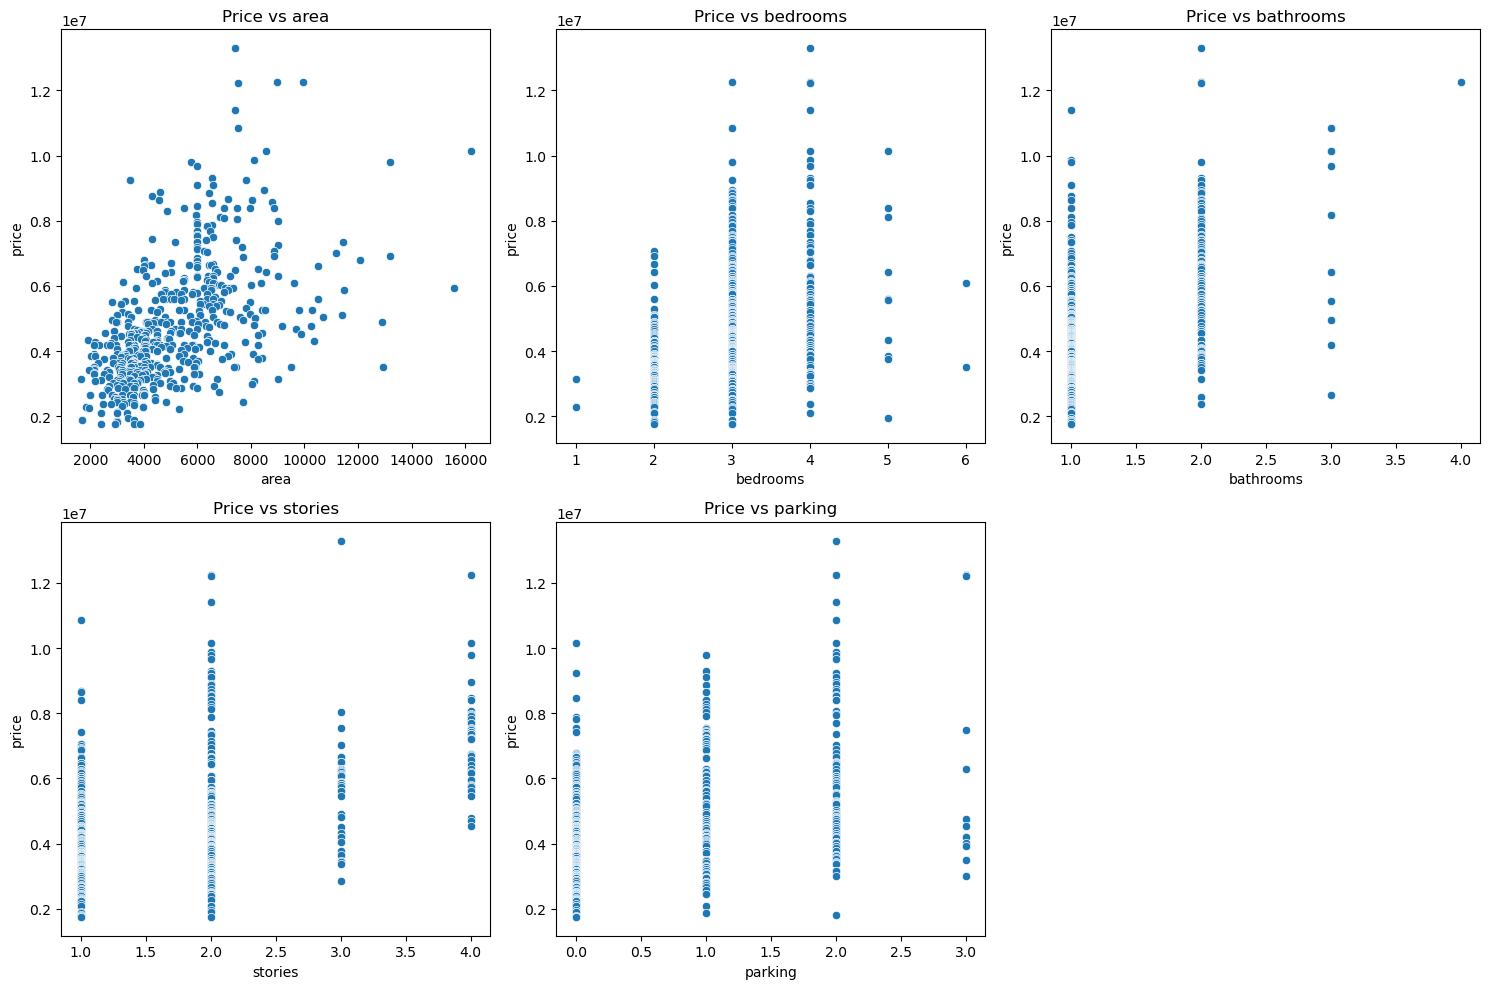

In [35]:
# Relationship between features and price
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols[1:], 1):  
    plt.subplot(2, 3, i)
    sns.scatterplot(data=df, x=col, y='price')
    plt.title(f'Price vs {col}')
plt.tight_layout()
plt.show()

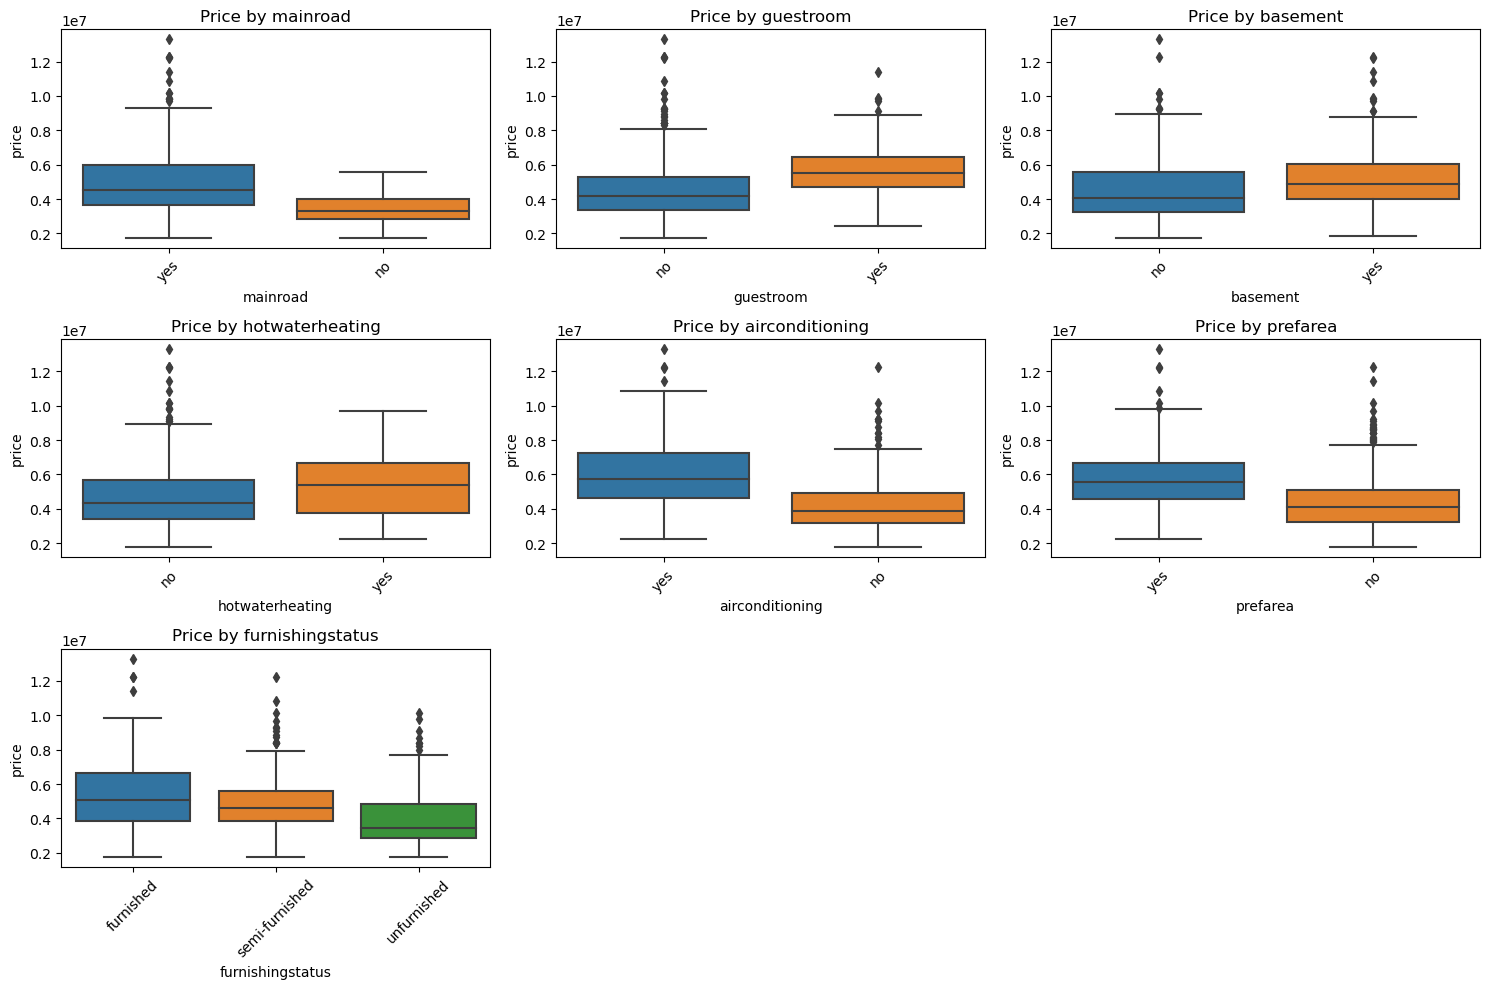

In [36]:
# Boxplots for categorical features vs price
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data=df, x=col, y='price')
    plt.title(f'Price by {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Data Preprocessing and Feature Engineering

In [37]:
#  Convert binary categorical features to numerical (0/1)
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
df[binary_cols] = df[binary_cols].apply(lambda x: x.map({'yes': 1, 'no': 0}))

In [38]:
# Handle furnishingstatus with one-hot encoding
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)

In [39]:
# Check for outliers (using z-score for numerical columns)
from scipy import stats
z_scores = np.abs(stats.zscore(df[numerical_cols[1:]]))  # Exclude price
df = df[(z_scores < 3).all(axis=1)]  # Remove outliers beyond 3 standard deviations

### Feature Scaling and Train-Test Split

In [40]:
#  Separate features and target
X = df.drop('price', axis=1)
y = df['price']


In [41]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [42]:
# Define numerical and categorical features
numerical_features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
binary_features = binary_cols
categorical_features = ['furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']


In [43]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('binary', 'passthrough', binary_features),
        ('cat', 'passthrough', categorical_features)
    ])


###  Model Training

In [44]:
#  Linear Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['area', 'bedrooms',
                                                   'bathrooms', 'stories',
                                                   'parking']),
                                                 ('binary', 'passthrough',
                                                  ['mainroad', 'guestroom',
                                                   'basement',
                                                   'hotwaterheating',
                                                   'airconditioning',
                                                   'prefarea']),
                                                 ('cat', 'passthrough',
                                                  ['furnishingstatus_semi-furnished',
                                                   'furnishingstatus_unfurnished'])])),
                ('regressor', LinearRegression())])

In [45]:
# Gradient Boosting
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ))
])

gb_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['area', 'bedrooms',
                                                   'bathrooms', 'stories',
                                                   'parking']),
                                                 ('binary', 'passthrough',
                                                  ['mainroad', 'guestroom',
                                                   'basement',
                                                   'hotwaterheating',
                                                   'airconditioning',
                                                   'prefarea']),
                                                 ('cat', 'passthrough',
                                                  ['furnishingstatus_semi-furnished',
                                                   'furnishingstatus_unfurnished'])])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

### Model Evaluation


Linear Regression Evaluation:
Mean Absolute Error (MAE): 845,304.69
Root Mean Squared Error (RMSE): 1,246,397.96
R-squared (R2) Score: 0.6751


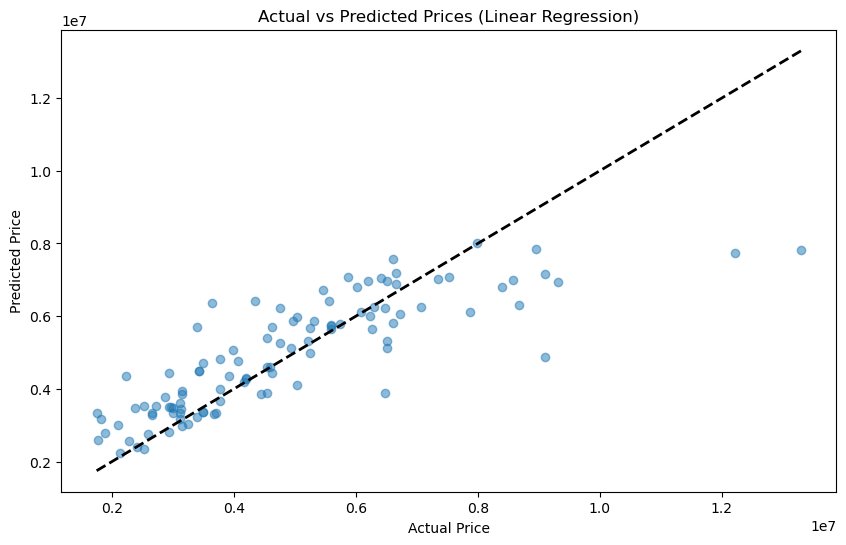

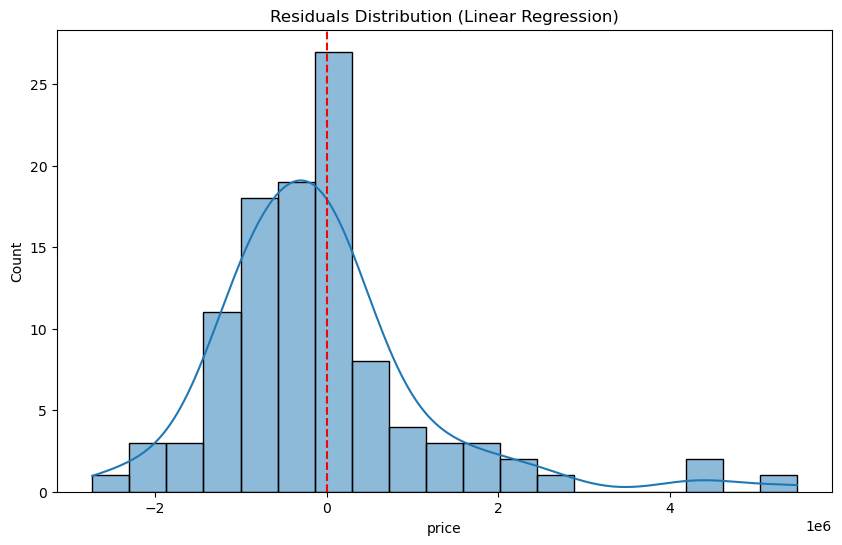


Gradient Boosting Evaluation:
Mean Absolute Error (MAE): 914,890.27
Root Mean Squared Error (RMSE): 1,249,981.73
R-squared (R2) Score: 0.6732


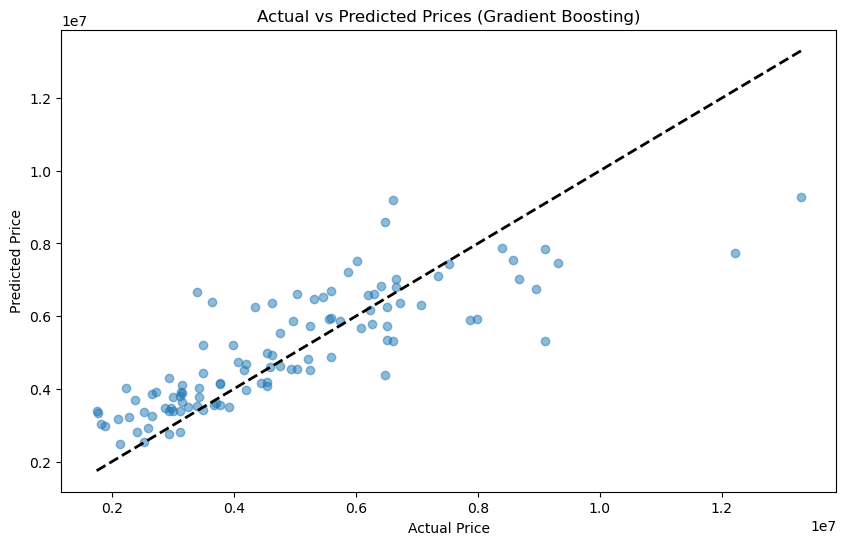

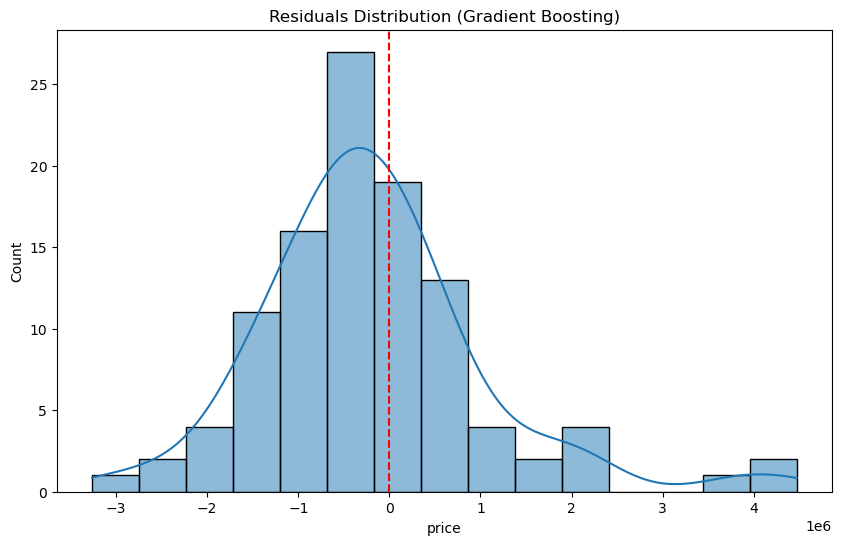

In [46]:
#  Model Evaluation

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name} Evaluation:")
    print(f"Mean Absolute Error (MAE): {mae:,.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
    print(f"R-squared (R2) Score: {r2:.4f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'Actual vs Predicted Prices ({model_name})')
    plt.show()
    
    # Plot residuals
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'Residuals Distribution ({model_name})')
    plt.show()
    
    return mae, rmse, r2

# Evaluate Linear Regression
y_pred_lr = lr_pipeline.predict(X_test)
mae_lr, rmse_lr, r2_lr = evaluate_model(y_test, y_pred_lr, "Linear Regression")

# Evaluate Gradient Boosting
y_pred_gb = gb_pipeline.predict(X_test)
mae_gb, rmse_gb, r2_gb = evaluate_model(y_test, y_pred_gb, "Gradient Boosting")

### Feature Importance Analysis

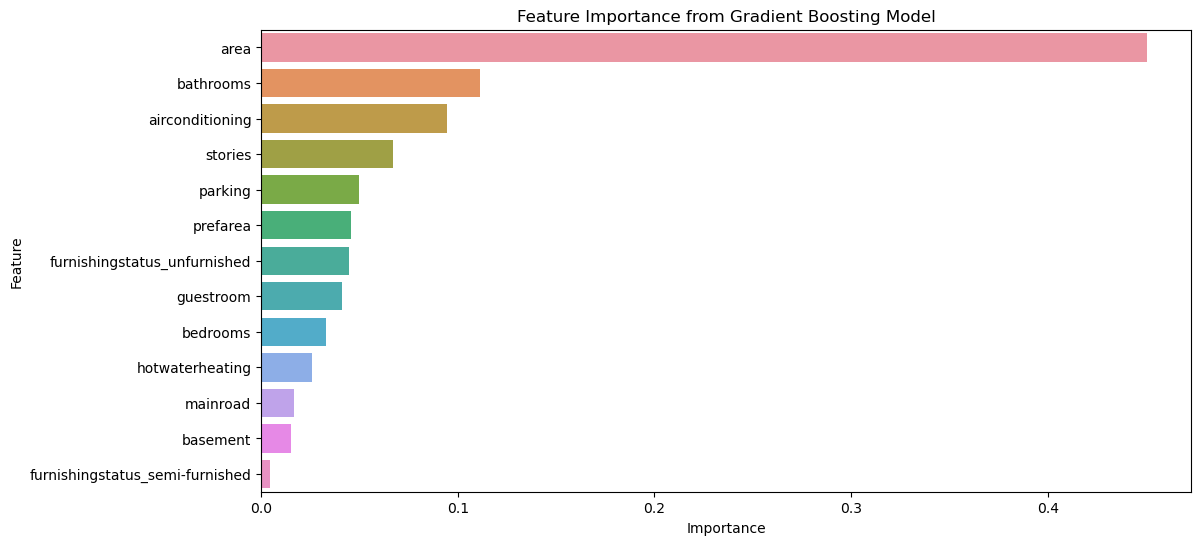

In [47]:
# Feature Importance Analysis
feature_names = numerical_features + binary_features + categorical_features
importances = gb_pipeline.named_steps['regressor'].feature_importances_

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance from Gradient Boosting Model')
plt.show()

### Model Comparison

In [48]:
# Model Comparison
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Gradient Boosting'],
    'MAE': [mae_lr, mae_gb],
    'RMSE': [rmse_lr, rmse_gb],
    'R2 Score': [r2_lr, r2_gb]
})

print("\nFinal Model Comparison:")
print(results)


Final Model Comparison:
               Model            MAE          RMSE  R2 Score
0  Linear Regression  845304.685536  1.246398e+06  0.675064
1  Gradient Boosting  914890.266983  1.249982e+06  0.673193
